# PCA of Thousand Genomes genotype matrix

Here we show using the partitioned thousand genomes data in the CanDIG repositories (and using the genotype matrix API) to reproduce extended data Figure 6 of "An integrated map of structural variation in 2,504 human genomes",   http://www.nature.com/nature/journal/v526/n7571/fig_tab/nature15394_SF6.html

In [1]:
from __future__ import print_function
from ga4gh.client import client
import pandas as pda
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

%matplotlib notebook

The following cell contains utility routines for plotting (to match thousand genomes figures) and for merging genotype matrices and metadata from different servers

In [2]:
import requests
from requests.packages.urllib3.exceptions import InsecureRequestWarning
requests.packages.urllib3.disable_warnings(InsecureRequestWarning)

    
def population_to_colors(populations):
    """
    Match colors in our plots to those used in Thousand Genomes plots
    """
    pop_to_rgb = { 'ACB': (0.84, 0.52, 0.13, 1.0), 'GWD': (0.96, 0.92, 0.18, 1.0),
                   'BEB': (0.37, 0.07, 0.43, 1.0), 'PEL': (0.71, 0.02, 0.1, 1.0),
                   'LWK': (0.72, 0.6, 0.3, 1.0), 'MSL': (0.8, 0.67, 0.15, 1.0),
                   'GBR': (0.48, 0.72, 0.79, 1.0), 'IBS': (0.35, 0.43, 0.66, 1.0),
                   'ASW': (0.77, 0.32, 0.11, 1.0), 'TSI': (0.12, 0.13, 0.32, 1.0),
                   'KHV': (0.39, 0.64, 0.22, 1.0), 'CEU': (0.17, 0.23, 0.53, 1.0),
                   'SAS': (0.52, 0.27, 0.54, 1.0), 'EAS': (0.67, 0.76, 0.15, 1.0),
                   'AMR': (0.45, 0.13, 0.11, 1.0), 'YRI': (0.92, 0.75, 0.36, 1.0),
                   'CHB': (0.67, 0.77, 0.16, 1.0), 'CLM': (0.62, 0.14, 0.16, 1.0),
                   'CHS': (0.45, 0.67, 0.19, 1.0), 'ESN': (0.94, 0.77, 0.14, 1.0),
                   'FIN': (0.39, 0.68, 0.74, 1.0), 'AFR': (0.97, 0.92, 0.24, 1.0),
                   'GIH': (0.32, 0.19, 0.5, 1.0), 'PJL': (0.69, 0.0, 0.45, 1.0),
                   'EUR': (0.53, 0.73, 0.84, 1.0), 'STU': (0.5, 0.25, 0.54, 1.0),
                   'MXL': (0.69, 0.0, 0.16, 1.0), 'ITU': (0.53, 0.13, 0.31, 1.0),
                   'CDX': (0.32, 0.56, 0.2, 1.0), 'JPT': (0.25, 0.49, 0.2, 1.0),
                   'PUR': (0.62, 0.14, 0.16, 1.0)}

    if type(populations) is list:
        colors = [ pop_to_rgb[pop] for pop in populations ] 
    else:
        colors = pop_to_rgb[populations]

    return colors

    
def get_ga4gh_genotypes_dataframe(url, chrom, start, end):
    chrom = chrom.replace('chr','')
    region = chrom+":"+str(start)+"-"+str(end)
    print ("chrom:{}, start:{}, end:{}".format(chrom, start, end))
    
    httpClient = client.HttpClient(url)
    
    datasets = list(httpClient.search_datasets())
    variantSets = list(httpClient.search_variant_sets(
        dataset_id=datasets[0].id))

    callSets = list(httpClient.search_call_sets(variantSets[0].id))

    iterator = httpClient.search_genotypes(
        variant_set_id=variantSets[0].id,
        reference_name=chrom, start=start, end=end,
        call_set_ids=[callset.id for callset in callSets])


    var_ids = ["%s_%s_%s_%s_%s" % (variant.reference_name,
                                   variant.start,
                                   variant.end,
                                   variant.reference_bases,
                                   "".join(variant.alternate_bases))
               for variant in iterator[1]]
    var_ids = np.matrix(var_ids)

    individuals = iterator[2]
    nvariants = iterator[0].nvariants
    nindividuals = iterator[0].nindividuals

    genotype_matrix = np.matrix(iterator[0].genotypes).reshape(nvariants, nindividuals).T

    # Add var_ids index
    genotype_matrix = np.concatenate((var_ids, genotype_matrix)).T

    # return DataFrame
    genotype_dataframe = pda.DataFrame(genotype_matrix, columns = ['index'] + list(individuals))

    return genotype_dataframe


def get_ga4gh_genotypes(servers, regions):
    """
    Returns a DataFrame of genotypes within the requested coordinates for all
    callsets. The data is merged from multiple ga4gh servers and multiple
    regions.
    """
    # When init == True,
    init = True

    num_servers = len(servers) - 1

    # for each server, query all regions then merge
    for j, server in enumerate(servers):

        G = pda.DataFrame()

        num_regions = len(regions) - 1
        for i, reg in enumerate(regions):
            # merge regions
            df = get_ga4gh_genotypes_dataframe(server, reg['chr'], reg['start'], reg['end'])
            G = G.append(df)
            print(j, '/', num_servers, '|',  i, '/', num_regions, '|', 'G:', G.shape, '\n')

            AllG = G
            init = False
        else:
            AllG = AllG.merge(G, how='outer', left_on='index', right_on='index')
        print('AllG:', AllG.shape, '\n')

    # replace all NaN with 0 -> assume 0/0
    AllG = AllG.fillna(0)

    return AllG

def get_ga4gh_subpops(server):
    import ga4gh.client.client

    baseURL = server
    client = ga4gh.client.client.HttpClient(baseURL)

    datasets = list(client.search_datasets())
    datasetId=datasets[0].id
    individuals = client.search_individuals(datasetId)
    ancestry_dict = { i.name: i.description for i in individuals }

    return ancestry_dict

Here we read a fraction of chromosome 20 to perform a PCA of the genotype matrix (this will take a few minutes)

In [11]:
# get matrix from two publically available servers
servers = [
    "https://ga4gh.ccm.sickkids.ca/ga4gh/",
    "http://ga4gh.pmgenomics.ca/ga4gh/",
]
regions = [
    {'chr':'chr20', 'start':1000000, 'end':2500000},
]

df = get_ga4gh_genotypes(servers, regions)
df = df.apply(pda.to_numeric, errors='ignore')
df = df.drop('index', axis=1)

chrom:20, start:1000000, end:2500000
0 / 1 | 0 / 0 | G: (28408, 836) 

AllG: (28408, 1671) 

chrom:20, start:1000000, end:2500000
1 / 1 | 0 / 0 | G: (28483, 836) 

AllG: (28483, 1671) 



In [12]:
# Get population data to go with samples we've seen:
subpops = {}
for server in servers:
    subpops.update(get_ga4gh_subpops(server))
    
subpop_list = np.array([subpops[sample[:-2]] for sample in list(df)])

Now we perform the PCA and plot the result.

<IPython.core.display.Javascript object>


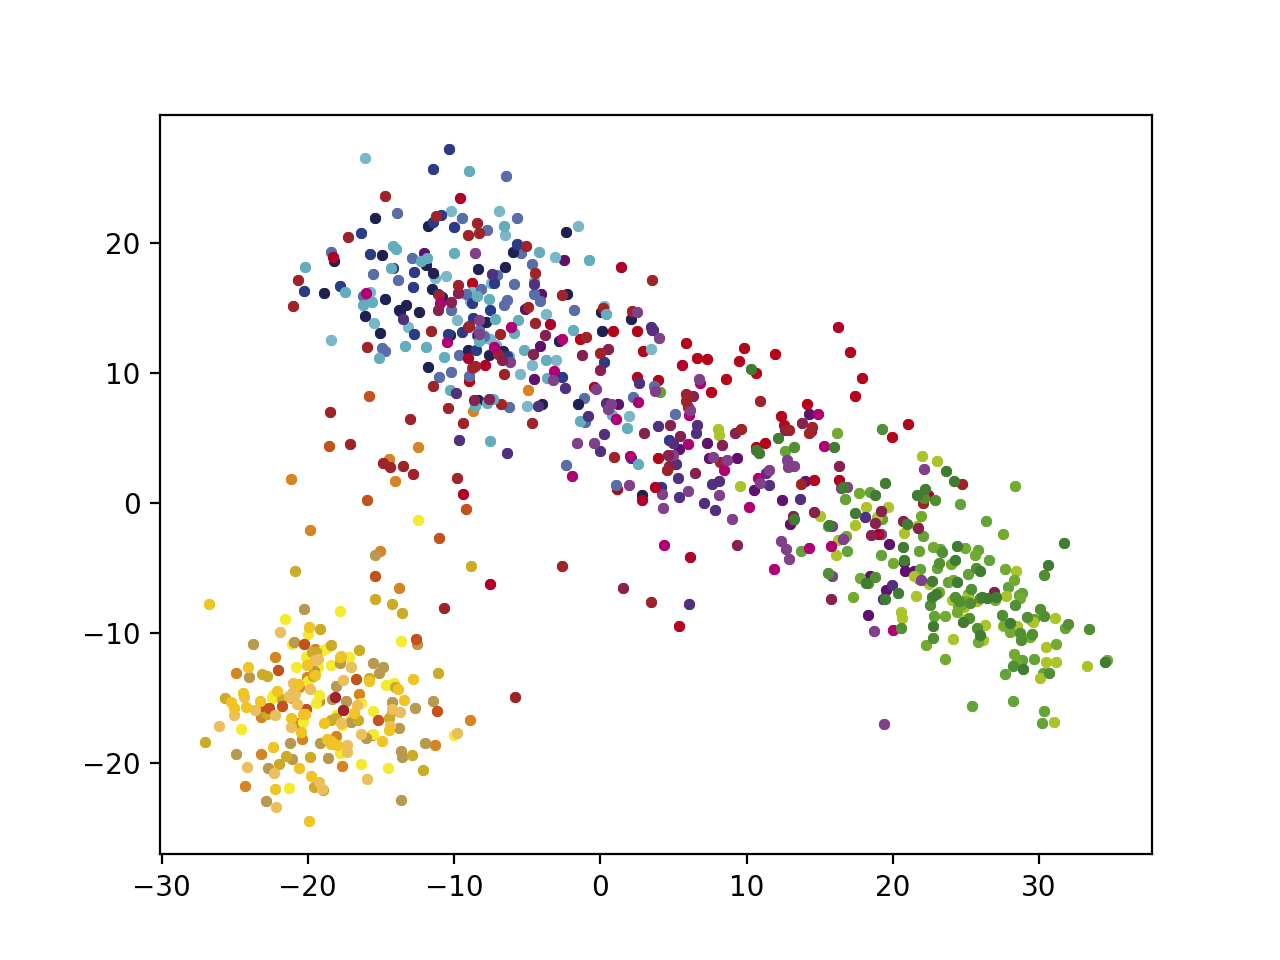

In [13]:
df = df.transpose()
pca = PCA(n_components=2)
y = pca.fit_transform(df)

for ancestry in ['ACB', 'GWD', 'BEB', 'PEL', 'LWK', 'MSL', 'GBR', 'IBS', 'ASW', 'TSI', 'KHV', 'CEU', 'SAS', 'EAS', 'AMR', 'YRI', 'CHB', 'CLM', 'CHS', 'ESN', 'FIN', 'AFR', 'GIH', 'PJL', 'EUR', 'STU', 'MXL', 'ITU', 'CDX', 'JPT', 'PUR']:
    color = population_to_colors(ancestry)
    idxs = np.where(subpop_list == ancestry)[0]
    plt.plot(y[idxs, 0], y[idxs, 1], '.', label=ancestry, color=color)